## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
from os.path import exists
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4536947480593234441
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32647086080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7260219703926005946
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2024-06-13 10:50:51.832525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [20]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/train_data/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath = empty_sky_filepath,
                                                                      dual_image_filepath = dual_AGN_filepath,
                                                                      stellar_filepath = stellar_filepath,
                                                                     offset_image_filepath = offset_AGN_filepath,
                                                                     single_image_filepath = single_AGN_filepath)
train_dataset, train_labels, train_filepaths = train_data_labels
val_dataset, val_labels, val_filepaths = val_data_labels
test_dataset, test_labels, test_filepaths = test_data_labels


2024-06-13 10:50:51,942 - INFO - Loading images from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ with label empty_sky...
100%|██████████| 9215/9215 [00:19<00:00, 467.27it/s]
9215it [00:57, 161.47it/s]
2024-06-13 10:52:10,819 - INFO - Loading images from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/ with label single_AGN...


Loaded 36860 images with 36860 labels from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/


100%|██████████| 2000/2000 [00:04<00:00, 491.69it/s]
2000it [00:20, 95.91it/s]
2024-06-13 10:52:36,276 - INFO - Loading images from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with label dual_AGN...


Loaded 12000 images with 12000 labels from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/
Length of single AGN images: 12000


100%|██████████| 14471/14471 [00:19<00:00, 735.35it/s]
2024-06-13 10:52:56,540 - INFO - expanding dims
2024-06-13 10:52:56,540 - INFO - Loading images from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/ with label offset_AGN...


Loaded 14471 images with 14471 labels from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/


100%|██████████| 28756/28756 [00:55<00:00, 514.67it/s]
2024-06-13 10:53:52,828 - INFO - expanding dims
2024-06-13 10:53:52,828 - INFO - Loading images from data_preprocessing/training_datasets/stellar_dataset/train_data/ with label star_AGN_align...


Loaded 28756 images with 28756 labels from data_preprocessing/training_datasets/offset_AGN_datasets/train_data/


 60%|█████▉    | 16950/28319 [00:24<00:15, 741.36it/s]WARNING: File may have been truncated: actual file length (38224) is smaller than the expected size (40320) [astropy.io.fits.file]
2024-06-13 10:54:17,244 - WARNING - File may have been truncated: actual file length (38224) is smaller than the expected size (40320)
100%|██████████| 28319/28319 [00:45<00:00, 628.52it/s]
2024-06-13 10:54:38,308 - INFO - expanding dims


Loaded 28319 images with 28319 labels from data_preprocessing/training_datasets/stellar_dataset/train_data/
Length of stellar images: (28319, 94, 94)
Total images: (120406, 94, 94, 1)
Total labels: (120406,)
Total filepaths: (120406,)
Train_dataset: (78263, 94, 94, 1)
Train_labels: (78263,)
Train_filepaths: (78263,)
Val_dataset: (24081, 94, 94, 1)
Val_labels: (24081,)
Val_filepaths: (24081,)
Test_dataset: (18062, 94, 94, 1)
Test_labels: (18062,)
Test_filepaths: (18062,)


In [21]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

(24081, 94, 94, 1)
(24081,)


In [22]:
image_shape = (94,94,1)
epoch = 20
batch_size = 64
init_learning_rate = 1e-5
num_classes = 5
model_type = 'dualfinder'
importance_score = [1.0, 1.0]

dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, importance_score, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(save_feature_maps = False)

['empty_sky' 'empty_sky' 'offset_AGN' ... 'empty_sky' 'star_AGN_align'
 'star_AGN_align']
['empty_sky' 'dual_AGN' 'empty_sky' ... 'star_AGN_align' 'star_AGN_align'
 'empty_sky']
Converting to list
Converting to list
train_labels shape: (78263, 5)
val_labels shape: (24081, 5)
Unique train labels: [0. 1.]
Unique val labels: [0. 1.]
5
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 94, 94, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 94, 94, 64)        640       
                                                                 
 dropout_16 (Dropout)        (None, 94, 94, 64)        0         
                                                                 
 batch_normalization_14 (Ba  (None, 94, 94, 64)        256       
 tchNormalization)                                

2024-06-13 10:54:43,771 - INFO - 'save_feature_maps' == False, NOT saving feature maps


train_images shape: (78263, 94, 94, 1)
train_labels shape: (78263, 5)
val_images shape: (24081, 94, 94, 1)
val_labels shape: (24081, 5)
Epoch 1/20


2024-06-13 10:54:48.455247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2446/2446 [==============================] - ETA: 0s - loss: 26.8625 - accuracy: 0.9605 - precision: 0.9683 - recall: 0.9525 - f1_score: 0.9480INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-13 10:56:50,577 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2446/2446 [==============================] - 124s 49ms/step - loss: 26.8625 - accuracy: 0.9605 - precision: 0.9683 - recall: 0.9525 - f1_score: 0.9480 - val_loss: 21.1197 - val_accuracy: 0.6977 - val_precision: 0.7079 - val_recall: 0.6906 - val_f1_score: 0.6162
Epoch 2/20
1353/2446 [===============>..............] - ETA: 47s - loss: 17.0456 - accuracy: 0.9908 - precision: 0.9910 - recall: 0.9904 - f1_score: 0.9877

KeyboardInterrupt: 

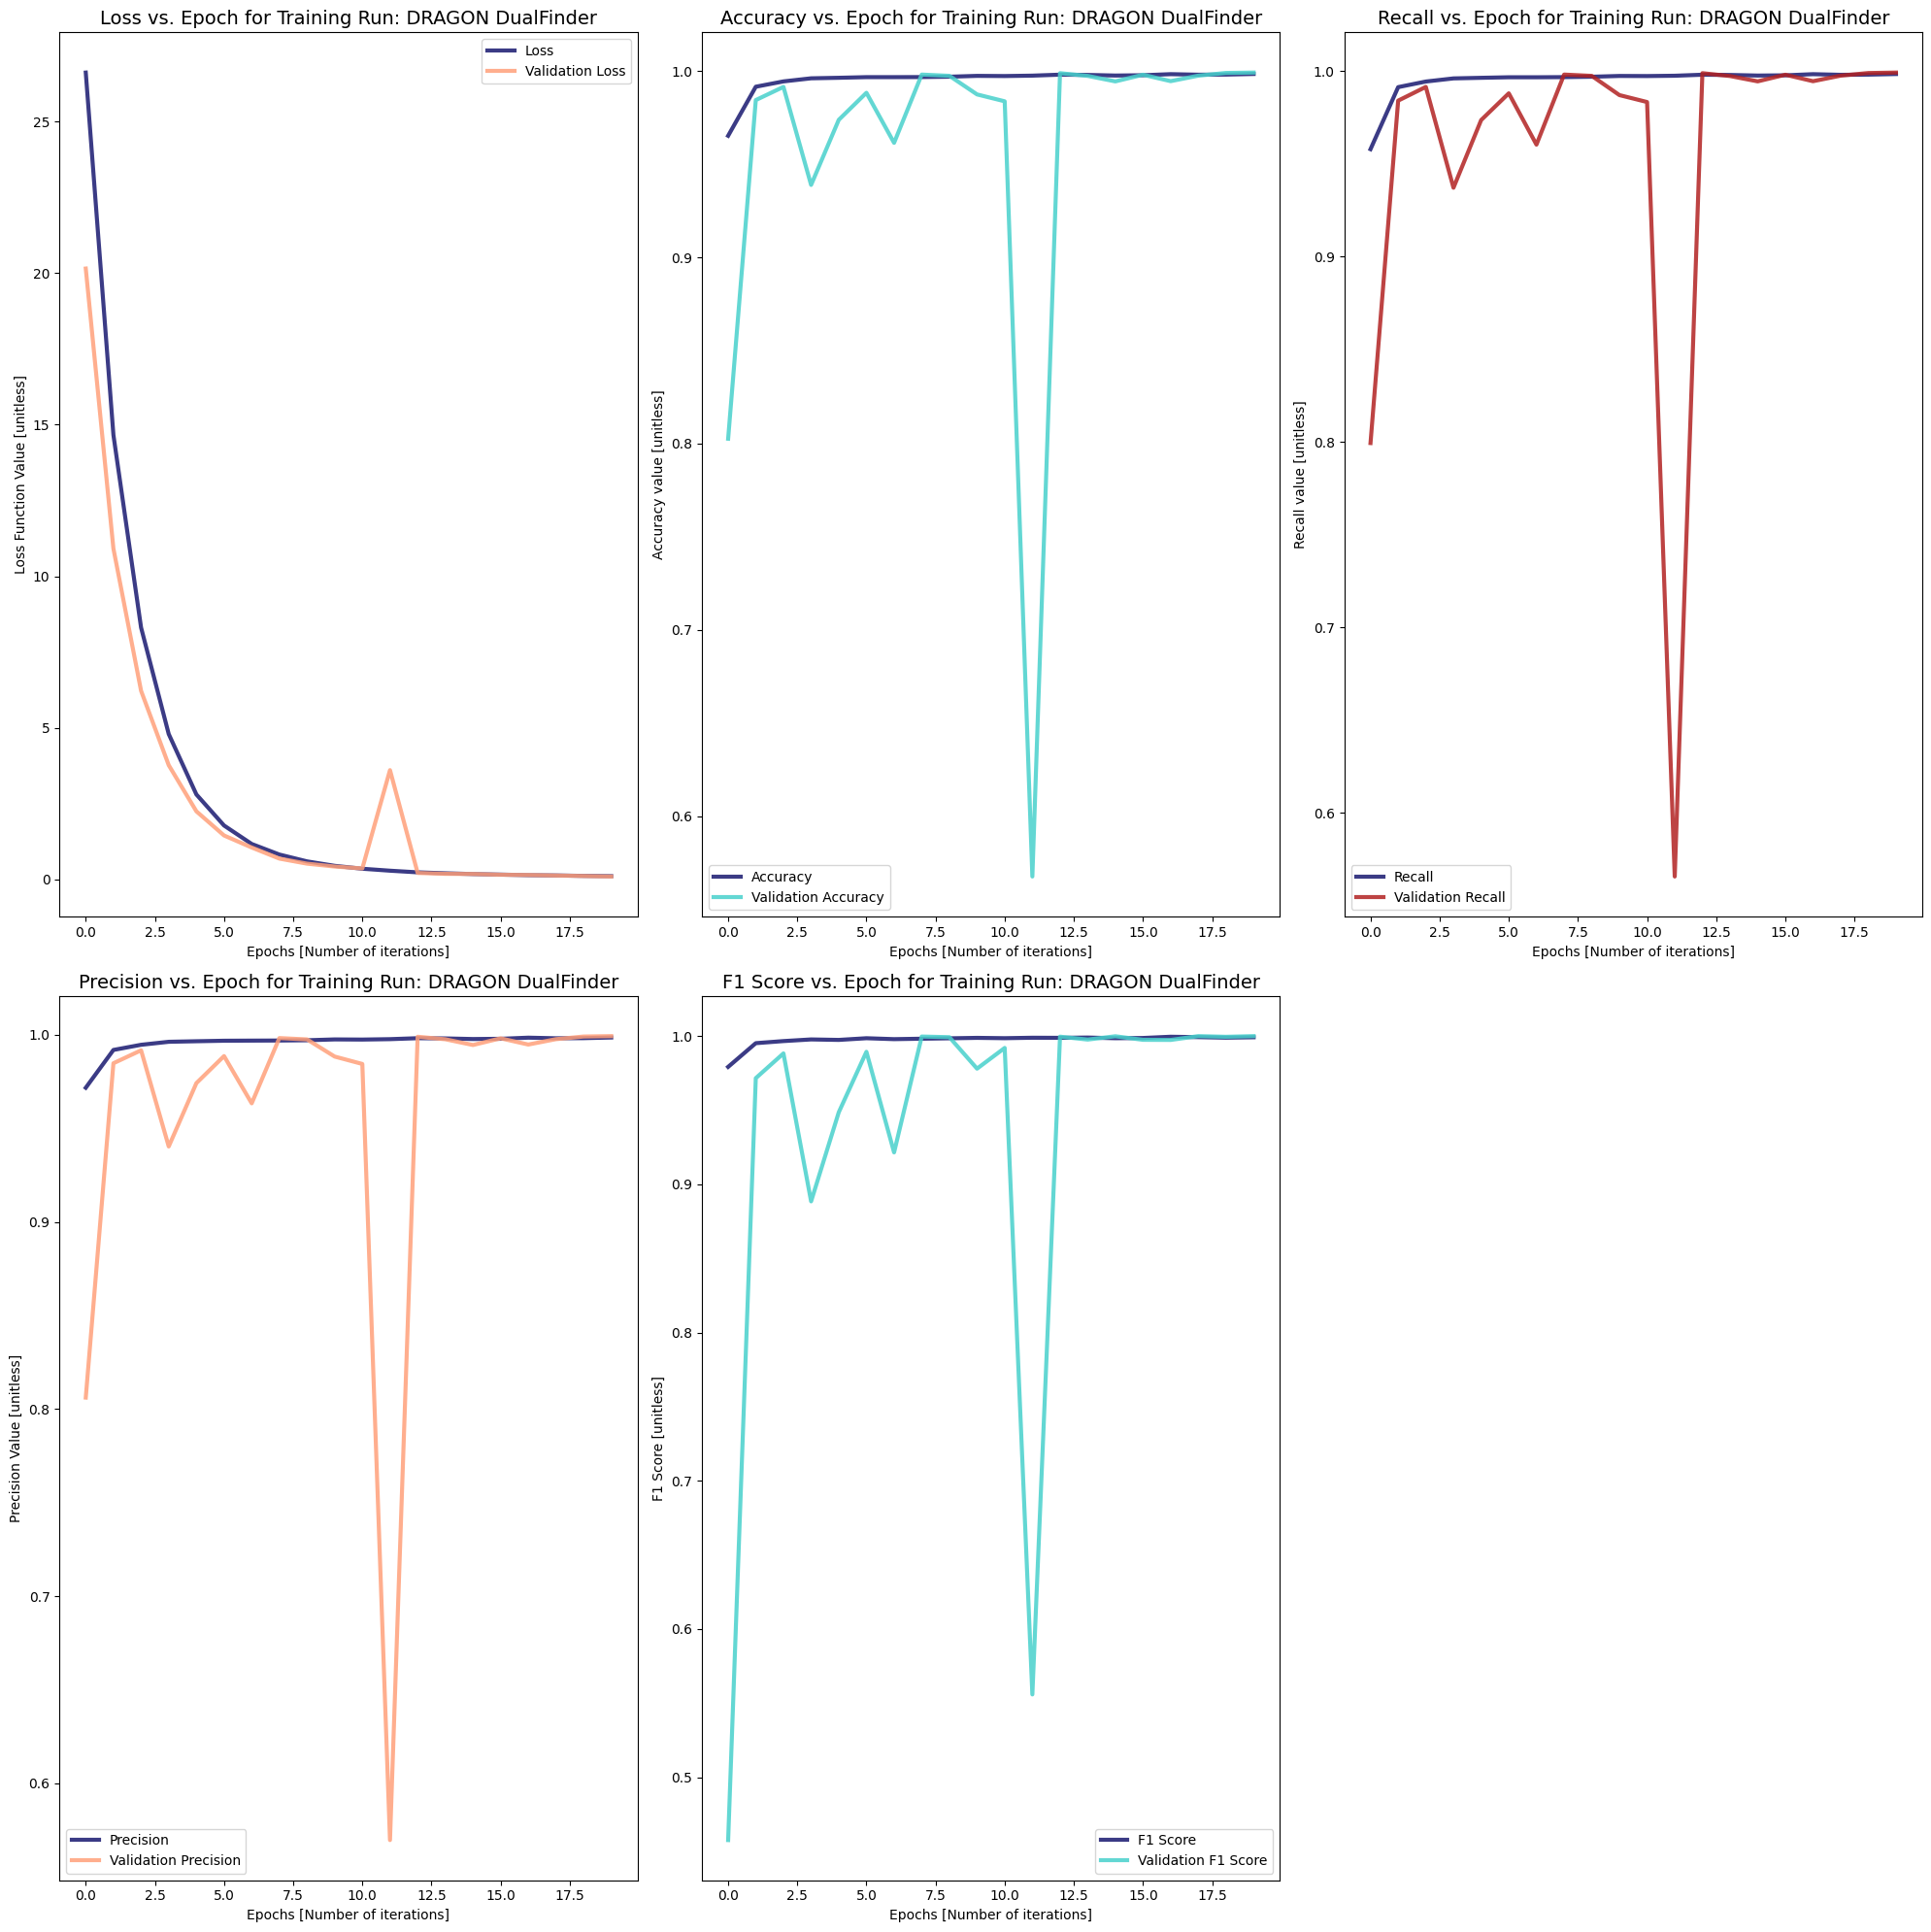

In [15]:
#print(history)
#print(type(history))
#print(history.history)
accuracy = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision']
recall = history.history['recall']
f1score = history.history['f1_score']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_f1score = history.history['val_f1_score']
training_epochs = np.arange(0, epoch)
fig_save_filepath = 'DRAGON_Dual_Finder/saved_training_figures/'
if not exists(fig_save_filepath):
    os.makedirs(fig_save_filepath)
fig, ax = plot_training_progress(loss, accuracy, training_epochs, save_filepath = fig_save_filepath, training_run = "DRAGON DualFinder",
                                 recall = recall, precision = precision, f1_score = f1score,
                                 val_loss = val_loss, val_acc = val_accuracy, val_recall = val_recall, val_precision = val_precision, 
                                 val_f1_score = val_f1score)

In [16]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['offset_AGN' 'dual_AGN' 'dual_AGN' ... 'offset_AGN' 'dual_AGN'
 'empty_sky']
['offset_AGN' 'dual_AGN' 'dual_AGN' ... 'offset_AGN' 'dual_AGN'
 'empty_sky']
Converting to list
Converting to list
282/282 [==============================] - 6s 20ms/step - loss: 0.0886 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - f1_score: 0.9988


[0.0886228159070015,
 0.9991120100021362,
 0.9991120100021362,
 0.9991120100021362,
 array([0.99856687, 1.        , 0.9956308 , 1.        , 1.        ],
       dtype=float32)]

In [ ]:
len("data_preprocessing/training_datasets/")

564/564 [==============================] - 5s 9ms/step
data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ra_189.60234289879924_dec_-1 with predicted label: empty_sky and confidence: 0.9999996423721313
data_preprocessing/training_datasets/stellar_dataset/train_data with predicted label: star_AGN_align and confidence: 0.9999997615814209
data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ra_189.5128692145887_dec_-1.4 with predicted label: empty_sky and confidence: 0.9999974966049194
data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ra_189.58444816195714_dec_-2. with predicted label: empty_sky and confidence: 0.9999977350234985
data_preprocessing/training_datasets/offset_AGN_datasets/train_data with predicted label: offset_AGN and confidence: 0.9999991655349731
data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ra_189.3607639514308_dec_-1.4 with predicted label: empty_sky a

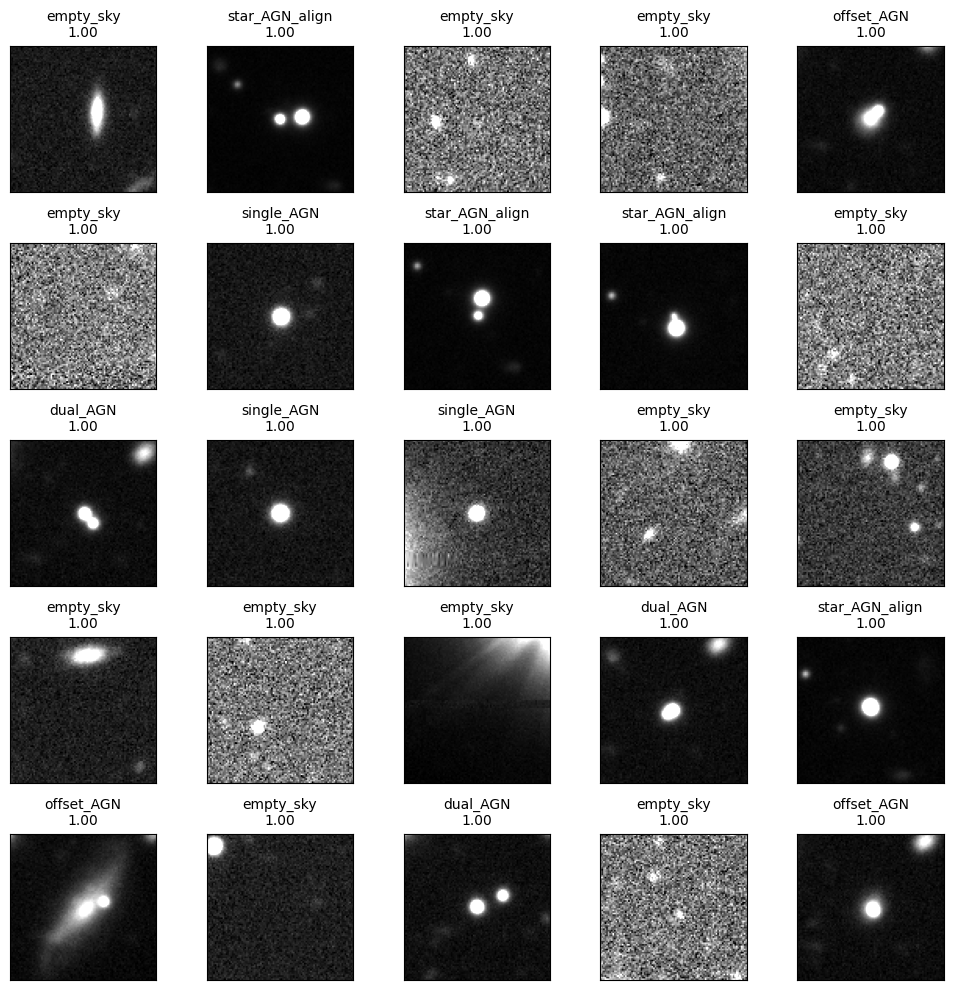

In [18]:
dual_finder_instance.predict(dual_finder_model, test_dataset, test_filepaths)